In [2]:
import pandas as pd
from pathlib import Path

DATA_PATH = 'data'

file_name = (
    Path('tables_OZ_geo_5500') /
    'Ozon_Crawler_Latest_info2025-04-07-12-57-51.xlsx'
)

cols_to_rename = {
        'Sku (Sku)': 'sku',
        'Название товара (ProductName)': 'name',
        'Описание (Description)': 'description',
        'Ссылка на карточку': 'url',
        'Продавец (SellerName)': 'seller'
    }

source_df = pd.read_excel(Path(DATA_PATH) / file_name)
source_df = (
    source_df
    .rename(columns=cols_to_rename)
)
source_df.head(1)

,sku,Фото (CoverImage),name,seller,Бренд (BrandName),Название категории (CategoryName),Цена соинвест (DiscountPrice),Цена по карте (OzonCardPrice),Сток FBO (StockFbm),Сток FBS (StockFbs),Ошибка загрузки (CrawlerError),Валюта (Currency),Цена до скидки (BasePrice),Рейтинг товара (AvgRating),Количество отзывов (Reviews),description,Rich-контент (RichContent),url,SellerProductId (SellerProductId)
0,1871769771,https://cdn1.ozone.ru/s3/multimedia-1-b/732378...,"Карты МИРА и РОССИИ настенные политические,160...",ИНТЕРТРЕЙД,Атлас Принт,Карты мира,1785.0,1649,0,34,0,RUB,3867.0,5.0,1,Представляем вашему вниманию уникальный набор ...,NaN,https://www.ozon.ru/product/karty-mira-i-rossi...,191942573


In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
DATA_PATH = 'data'

moscow_file_name = (
    Path('tables_OZ_geo_5500') /
    'mosсow_maps.xlsx'
)
moscow_source_df = pd.read_excel(Path(DATA_PATH) / moscow_file_name)
moscow_source_df = (
    moscow_source_df
    .rename(columns={col: col.lower() for col in moscow_source_df.columns})
)
moscow_source_df.head(1)

,sku,name,thumb
0,508611672,Карта Москвы и Московской области настенная 14...,https://cdn1.ozone.ru/s3/multimedia-1-s/727829...


In [5]:
# Collect images

import nest_asyncio
nest_asyncio.apply()

from utils import parallel_download_img

# Dataset name
DATASET_NAME = "images_OZ_geo_5500"

# Download image files using the 'Thumb' column for both URL and ID extraction
results = await parallel_download_img(
    df=source_df,
    url_col='Фото (CoverImage)',
    img_id_regex=r'/(\d+)\.jpg$',  # capture numeric ID before '.jpg'
    dataset_name=DATASET_NAME,
    base_download_dir=DATA_PATH,
    max_concurrency=100,
    delay=1.0
)

Error downloading https://cdn1.ozone.ru/s3/multimedia-1-f/6957492927.jpg: 


In [7]:
# Merge the list of results into your DataFrame as a new column
source_df['image_name'] = results

Image name: 6878486506.jpg
Name: настенная карта Республики Коми 113 х 98 см (на баннере)


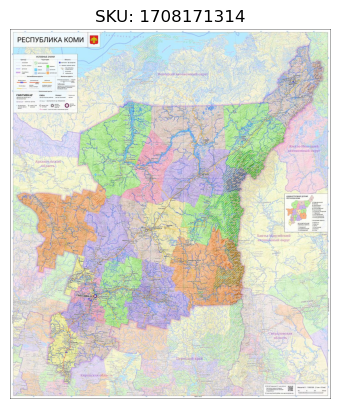

In [ ]:
import PIL.Image
import matplotlib.pyplot as plt
from pathlib import Path

# Sample a single row
sample_row = source_df.sample(1).iloc[0]

# Construct the image path
img_path = Path(DATA_PATH) / DATASET_NAME / sample_row['image_name']

# Print the image name
print("Image name:", sample_row['image_name'])
print("Name:", sample_row['name'])

# Load and display the image
img = PIL.Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"SKU: {sample_row['sku']}")
plt.show()


In [29]:
# Identify erroneous indices where image_name is None
erroneous_indices = source_df[source_df.image_name.isna()].index

# Print the erroneous indices
print("Erroneous indices:")
print(erroneous_indices)

Erroneous indices:
Index([2047, 2802, 2877], dtype='int64')


In [24]:
# Save images and names

target_file_path = (
    Path(DATA_PATH) /
    Path('tables_OZ_geo_5500') /
    Path('processed') / 
    Path('OZ_geo_5500.csv')
)

moscow_target_file_path = (
    Path(DATA_PATH) /
    Path('tables_OZ_geo_5500') /
    Path('processed') / 
    Path('OZ_geo_Moscow_30.csv')
)

In [ ]:
# # Read file instead of downloading images
# target_df = pd.read_csv(target_file_path)

In [ ]:
target_df = (
    source_df[[
        'sku',
        'name',
        'description',
        'url',
        'seller',
        'image_name'
    ]]
    .drop(erroneous_indices)
)

target_df.to_csv(target_file_path, index=None)

In [ ]:
# Filter Moscow only

moscow_skus = moscow_source_df['sku'].tolist()
len(moscow_skus)

target_df[
    target_df['sku'].isin(moscow_skus)
].to_csv(moscow_target_file_path, index=None)